# Settings

In [1]:
# Connect to DB
from sqlalchemy import create_engine
from sqlalchemy import types
import mysql.connector
import yaml

# Data Analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import datetime as dt

# Data

In [2]:
with open("../config.yml", 'r') as config_doc:
    config = yaml.safe_load(config_doc)

def engine_str_formatter(config):
    return 'mysql+mysqlconnector://' + \
        config['user'] + ':' + \
        config['password'] + '@' + \
        config['host'] + '/' + \
        config['database']

engine = create_engine(engine_str_formatter(config))
cnx = engine.connect()

In [3]:
q = '''
    select * 
    from divvy_station_daily_trips
'''
df  = pd.read_sql(q, cnx)

In [4]:
df.shape

(670193, 5)

# Analysis

In [5]:
print(df.num_trips_from.sum() / df.shape[0])
print(df.num_trips_to.sum() / df.shape[0])

21.357884967464596
21.357755154112322


## Overall Pattern

In [6]:
dfg = df.groupby('ride_date').agg({'num_trips_from':['mean', 'std', 'sum'], 'num_trips_to':['mean', 'std', 'sum']})
dfg.head()

num_trips_from                  num_trips_to                 
                     mean        std   sum         mean        std   sum
ride_date                                                               
2013-06-27       1.938776   2.249149    95     1.938776   1.663432    95
2013-06-28       9.966667  10.238120   897     9.966667  10.018466   897
2013-06-29      12.131313  12.991871  1201    12.131313  13.821491  1201
2013-06-30      17.764706  21.223085  1812    17.764706  22.304453  1812
2013-07-01      15.135922  17.268950  1559    15.135922  17.559450  1559

Text(0.5,1,'Average Number of Divvy Rides Taken per Station')

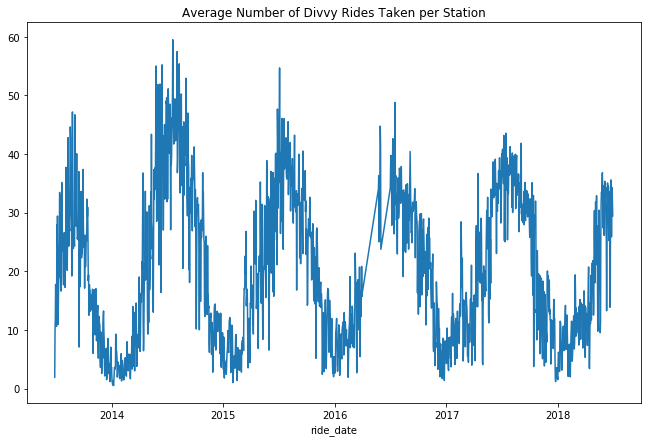

In [7]:
ax = dfg.num_trips_from['mean'].plot(figsize=(11,7))
ax.set_title('Average Number of Divvy Rides Taken per Station')

Interstingly, the _avg_ number or rides has decreased since it's peak in 2014. Perhaps this is because the total number of stations has gone up.

Text(0.5,1,'Average Number of Divvy Rides Taken per Station')

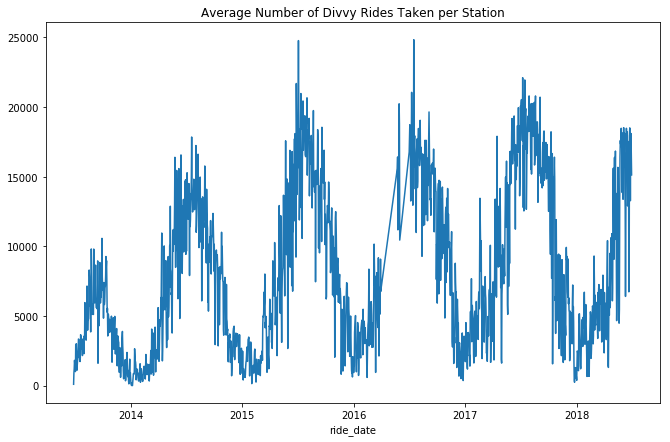

In [8]:
ax = dfg.num_trips_from['sum'].plot(figsize=(11,7))
ax.set_title('Average Number of Divvy Rides Taken per Station')

The total number of rides increased over time. That makes sense.

In [9]:
dfg.head()

num_trips_from                  num_trips_to                 
                     mean        std   sum         mean        std   sum
ride_date                                                               
2013-06-27       1.938776   2.249149    95     1.938776   1.663432    95
2013-06-28       9.966667  10.238120   897     9.966667  10.018466   897
2013-06-29      12.131313  12.991871  1201    12.131313  13.821491  1201
2013-06-30      17.764706  21.223085  1812    17.764706  22.304453  1812
2013-07-01      15.135922  17.268950  1559    15.135922  17.559450  1559

In [10]:
station_ids = df.station_id.unique()

In [11]:
len(station_ids)

573

## Example A Single Station's Pattern

station_id = 2 is Buckingham Fountain

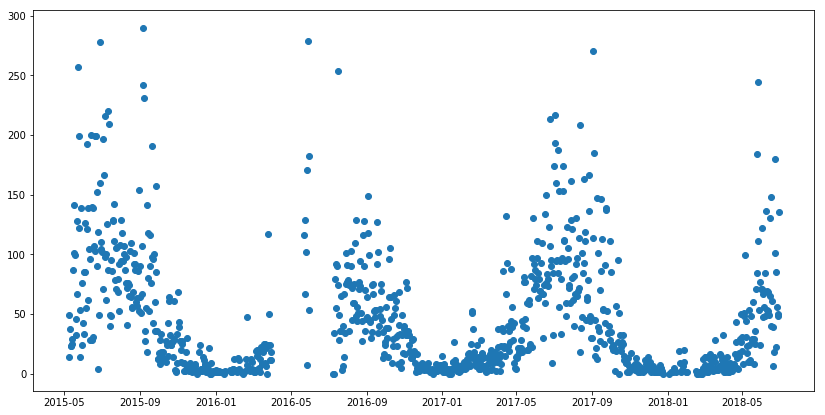

In [12]:
fig, ax = plt.subplots(figsize=(14,7))
df_2 = df[df.station_id == 2]
ax.plot_date(x=df_2.ride_date, y=df_2.num_trips_from)

## Finding High Usage Stations

In [13]:
dfg.head()

num_trips_from                  num_trips_to                 
                     mean        std   sum         mean        std   sum
ride_date                                                               
2013-06-27       1.938776   2.249149    95     1.938776   1.663432    95
2013-06-28       9.966667  10.238120   897     9.966667  10.018466   897
2013-06-29      12.131313  12.991871  1201    12.131313  13.821491  1201
2013-06-30      17.764706  21.223085  1812    17.764706  22.304453  1812
2013-07-01      15.135922  17.268950  1559    15.135922  17.559450  1559

In [14]:
dfx = df.merge(dfg.reset_index()[['ride_date','num_trips_from']], how='left', on='ride_date')
dfx.rename(columns={('num_trips_from', 'mean'):'avg', ('num_trips_from', 'std'):'sd'}, inplace=True)

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [15]:
dfx.head()

,station_id,ride_date,num_trips_from,num_trips_to,grid,avg,sd,"(num_trips_from, sum)"
0,2,2015-05-08,14,12,41888762,21.178295,24.267011,8196
1,2,2015-05-09,49,44,41888762,14.609375,14.798508,5610
2,2,2015-05-10,37,39,41888762,8.371968,8.380265,3106
3,2,2015-05-11,23,20,41888762,16.645244,18.220092,6475
4,2,2015-05-12,23,20,41888762,19.501253,21.175965,7781


In [16]:
dfx['normalized'] = (dfx.num_trips_from - dfx.avg) / dfx.sd

In [17]:
dfx['avg_plus_sd'] = dfx['avg'] + dfx['sd']
dfx['above_avg'] = dfx['num_trips_from'] > dfx['avg']

In [18]:
dfx.head()

,station_id,ride_date,num_trips_from,num_trips_to,grid,avg,sd,"(num_trips_from, sum)",normalized,avg_plus_sd,above_avg
0,2,2015-05-08,14,12,41888762,21.178295,24.267011,8196,-0.295805,45.445305,False
1,2,2015-05-09,49,44,41888762,14.609375,14.798508,5610,2.323925,29.407883,True
2,2,2015-05-10,37,39,41888762,8.371968,8.380265,3106,3.416125,16.752232,True
3,2,2015-05-11,23,20,41888762,16.645244,18.220092,6475,0.348777,34.865336,True
4,2,2015-05-12,23,20,41888762,19.501253,21.175965,7781,0.165223,40.677218,True


-0.026217673219374495
2.7423006362105675


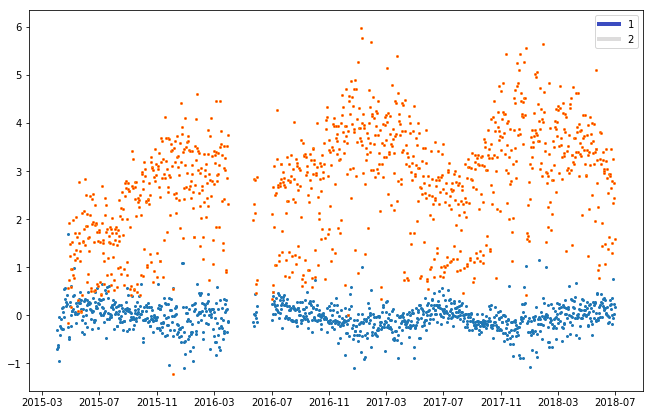

In [20]:
fig, ax = plt.subplots(figsize=(11, 7))

d = dfx[(dfx.station_id == 5) & (dfx.ride_date > pd.to_datetime('2015-04-01').date())]
print(np.mean(d.normalized))
ax.plot_date(d.ride_date, d.normalized, markersize=2)

d = dfx[dfx.station_id == 133]
print(np.mean(d.normalized))
ax.plot_date(d.ride_date, d.normalized, markersize=2, markerfacecolor='red')

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]
ax.legend(custom_lines, [1,2])


In [21]:
abv_avg = dfx.groupby('station_id').agg({'above_avg':['count', 'sum', 'mean']})
abv_avg.sort_values(('above_avg','mean'), ascending=False).head(10)

above_avg                  
               count     sum      mean
station_id                            
133             1081  1078.0  0.997225
199             1698  1683.0  0.991166
110             1706  1683.0  0.986518
56              1739  1710.0  0.983324
176             1708  1676.0  0.981265
195             1706  1667.0  0.977140
59              1742  1701.0  0.976464
44              1740  1682.0  0.966667
77              1744  1684.0  0.965596
43              1736  1673.0  0.963710

In [22]:
abv_avg[abv_avg.above_avg['mean'] > 0.5]

above_avg                  
               count     sum      mean
station_id                            
2                963   585.0  0.607477
3               1071   863.0  0.805789
4                994   661.0  0.664990
5               1730   876.0  0.506358
6               1028   699.0  0.679961
7               1086   705.0  0.649171
13              1735  1415.0  0.815562
18              1083   780.0  0.720222
20              1732  1023.0  0.590647
21              1735  1092.0  0.629395
24              1739  1650.0  0.948821
25              1736  1401.0  0.807028
26              1742  1675.0  0.961538
31              1738  1550.0  0.891830
33              1738  1525.0  0.877445
35              1680  1435.0  0.854167
36              1741  1644.0  0.944285
37              1736  1493.0  0.860023
38              1088  1018.0  0.935662
39              1085   912.0  0.840553
40              1059   590.0  0.557129
41              1081  1012.0  0.936170
43              1736  1673.0  0.963710
44              1740  1682.0  0.966667
45              1724  1183.0  0.686195
47              1741  1675.0  0.962091
48              1742  1389.0  0.797359
49              1743  1632.0  0.936317
50              1732  1230.0  0.710162
51              1738  1440.0  0.828539
...              ...     ...       ...
273             1663  1047.0  0.629585
283             1654  1290.0  0.779927
284             1657  1515.0  0.914303
286             1653  1221.0  0.738657
287             1654  1351.0  0.816808
289             1663  1600.0  0.962117
291             1659  1327.0  0.799879
296             1654  1039.0  0.628174
299             1645  1071.0  0.651064
300             1722  1233.0  0.716028
301             1653  1431.0  0.865699
303             1652  1113.0  0.673729
304             1656  1025.0  0.618961
313             1699  1130.0  0.665097
321             1654  1386.0  0.837969
327             1647  1061.0  0.644202
331             1630  1026.0  0.629448
332             1460   822.0  0.563014
334             1638  1015.0  0.619658
337             1642  1209.0  0.736297
340             1649  1417.0  0.859309
341             1618   992.0  0.613103
342             1625   860.0  0.529231
344             1627  1243.0  0.763983
349             1706  1005.0  0.589097
359             1070   691.0  0.645794
364             1072   658.0  0.613806
423             1084   647.0  0.596863
623              378   232.0  0.613757
627              115    73.0  0.634783

[151 rows x 3 columns]

Text(0.5,1,'Percent of Days that Station is Above Average for that Day')

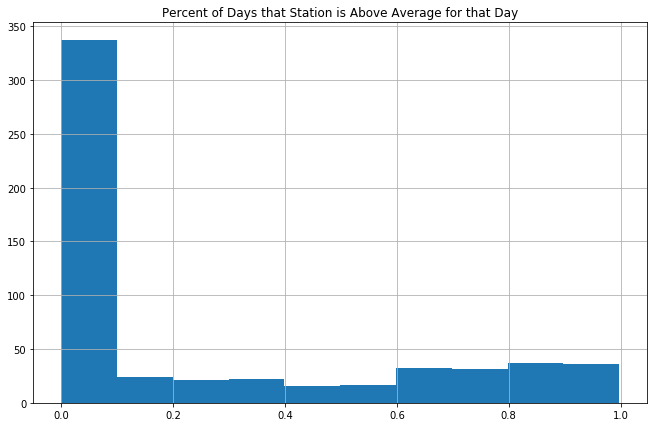

In [23]:
ax = abv_avg.above_avg['mean'].hist(figsize=(11,7))
ax.set_title('Percent of Days that Station is Above Average for that Day')

Text(0.5,1,'Percent of Days that Station is Above Average for that Day')

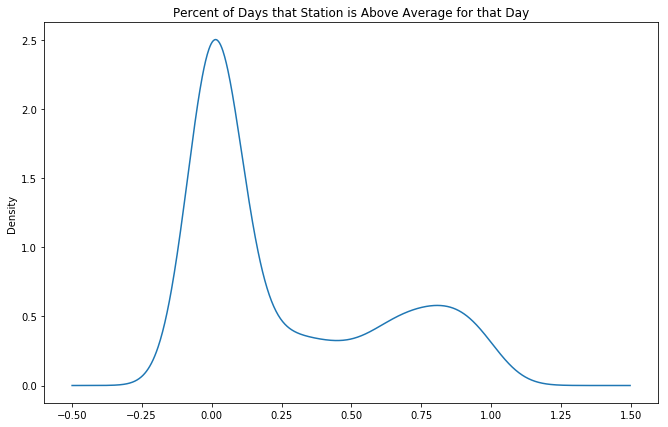

In [24]:
ax = abv_avg.above_avg['mean'].plot(kind='density', figsize=(11,7))
ax.set_title('Percent of Days that Station is Above Average for that Day')

In [26]:
df = pd.read_sql('''select * from daily_grid_activity where YEAR(trip_date) = 2016; ''', cnx)

In [29]:
df.groupby('grid').sum().sort_values('cta_rides', ascending=False).head(10)

,taxi_pickups,taxi_dropoffs,divvy_pickups,divvy_dropoffs,cta_rides
grid,,,,,
41888763,1590807.0,1277722.0,155358.0,151465.0,32519228.0
41898763,1143331.0,948441.0,112228.0,117203.0,15617125.0
41908763,1079265.0,836825.0,75096.0,73266.0,7994432.0
41938765,36518.0,51142.0,47888.0,48107.0,5847247.0
41878763,12905.0,45138.0,57880.0,56496.0,5272901.0
41948765,59435.0,56280.0,47595.0,49696.0,5226886.0
41958765,49098.0,43816.0,59710.0,61688.0,5016069.0
41988790,453228.0,311260.0,0.0,0.0,3989911.0
41728762,0.0,0.0,0.0,0.0,3463628.0
